In [2]:
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
import graphviz
from sklearn.tree import export_graphviz
from sklearn.decomposition import PCA
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans


In [3]:
# Define a function to create a scatter plot of our data and labels
def plot_data(X, y):
    plt.scatter(X[y == 0, 0], X[y == 0, 1], label="Class #0", alpha=0.5, linewidth=0.15)
    plt.scatter(X[y == 1, 0], X[y == 1, 1], label="Class #1", alpha=0.5, linewidth=0.15, c='r')
    plt.legend()
    return plt.show()

def prep_data(df: pd.DataFrame) -> (np.ndarray, np.ndarray):
    """
    Convert the DataFrame into two variable
    X: data columns (V1 - V28)
    y: lable column
    """
    X = df.iloc[:, 2:30].values
    y = df.fraud.values
    return X, y

def func(pct, allvals):
    absolute = int(round(pct/100.*np.sum(allvals)))
    return "{:.1f}%\n({:d} g)".format(pct, absolute)

def drawPieChart(label,data,title):
    fig, ax = plt.subplots(figsize=(6, 3), subplot_kw=dict(aspect="equal"))
    wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"))

    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(arrowprops=dict(arrowstyle="-"), bbox=bbox_props, zorder=0, va="center")

    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1)/2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = "angle,angleA=0,angleB={}".format(ang)
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
    
        ax.annotate(label[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)
    plt.title(title)
    plt.show


In [4]:
#url = "https://raw.githubusercontent.com/dnishimoto/python-deep-learning/master/creditcard.csv"
url="creditcard.csv"

creditcard = pd.read_csv(url)

creditcard.columns = [x.lower() for x in creditcard.columns]
creditcard.rename(columns = {'class': 'fraud'}, inplace = True)

print(creditcard.columns)
print(creditcard.fraud.value_counts(dropna = False))



Index(['time', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10',
       'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'v17', 'v18', 'v19', 'v20',
       'v21', 'v22', 'v23', 'v24', 'v25', 'v26', 'v27', 'v28', 'amount',
       'fraud'],
      dtype='object')
0    56772
1      102
Name: fraud, dtype: int64


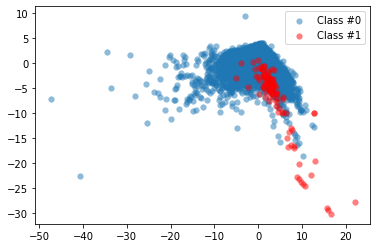

In [5]:
X, y = prep_data(creditcard)
plot_data(X, y)

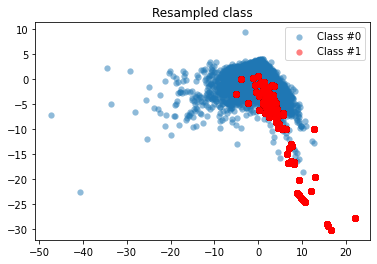

In [6]:
method=RandomOverSampler()

X_resampled, y_resampled = method.fit_sample(X,y)

plt.title("Resampled class")
plot_data(X_resampled, y_resampled)


In [7]:
X = creditcard.drop("fraud", axis = 1)
y = creditcard["fraud"]


X_train, X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=42)

Accuracy 0.7147797724927678
The confusion matrix is based on probabilities.  Logistic Regression provide probabilities for true negative and true positive


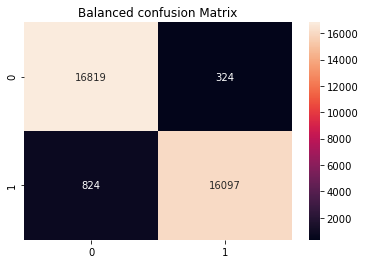

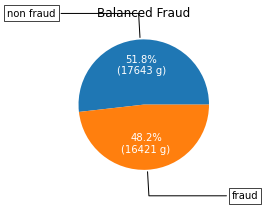

In [8]:
X2_train, X2_test,y2_train,y2_test=train_test_split(X_resampled,y_resampled,test_size=0.3,random_state=42)
model = LinearRegression()
model.fit(X2_train,y2_train)
y2_predicted=model.predict(X2_test)
print("Accuracy",metrics.r2_score(y2_test,y2_predicted))

print('The confusion matrix is based on probabilities.  Logistic Regression provide probabilities for true negative and true positive')

lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X2_train,y2_train)
lr_y2_predicted = lr_model.predict(X2_test)
lr_y2_pred_proba=lr_model.predict_proba(X2_test)

plt.title("Balanced confusion Matrix")
conf_mat=confusion_matrix(y_true=y2_test,y_pred=lr_y2_predicted)
sns.heatmap(conf_mat,annot=True,fmt='g')
plt.show()

results=[]
threshold=0.5
lr_y2_pred_proba_df=pd.DataFrame({"proba_default":lr_y2_pred_proba[:,1]})
results=lr_y2_pred_proba_df['proba_default'].apply(lambda row: 1 if row>threshold else 0)

drawPieChart(['non fraud','fraud'],results.value_counts(),"Balanced Fraud")
#plt.pie(results.value_counts())



In [9]:
print("Random Forest Classifier")

Random Forest Classifier


Random Forest Model accuracy 0.999531149270351


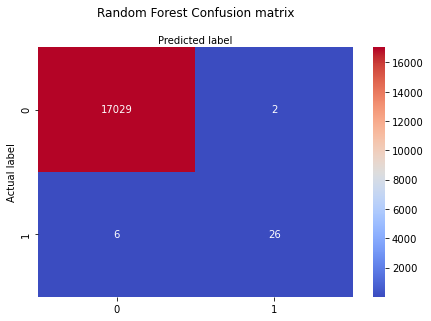

In [10]:
rf_pipeline= Pipeline([
   ('scaler',StandardScaler()),
    ('pca', PCA()),
   ('clf',RandomForestClassifier(criterion='gini',n_estimators=10,max_depth=8,min_samples_leaf=3, max_features=12, random_state=42))
])
rf_pipeline.fit(X_train,y_train)
rf_y_pred = rf_pipeline.predict(X_test)

cm=confusion_matrix(y_test,rf_y_pred)

class_names=[1,2]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="coolwarm" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Random Forest Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')


print("Random Forest Model accuracy",metrics.accuracy_score(y_test,rf_y_pred))


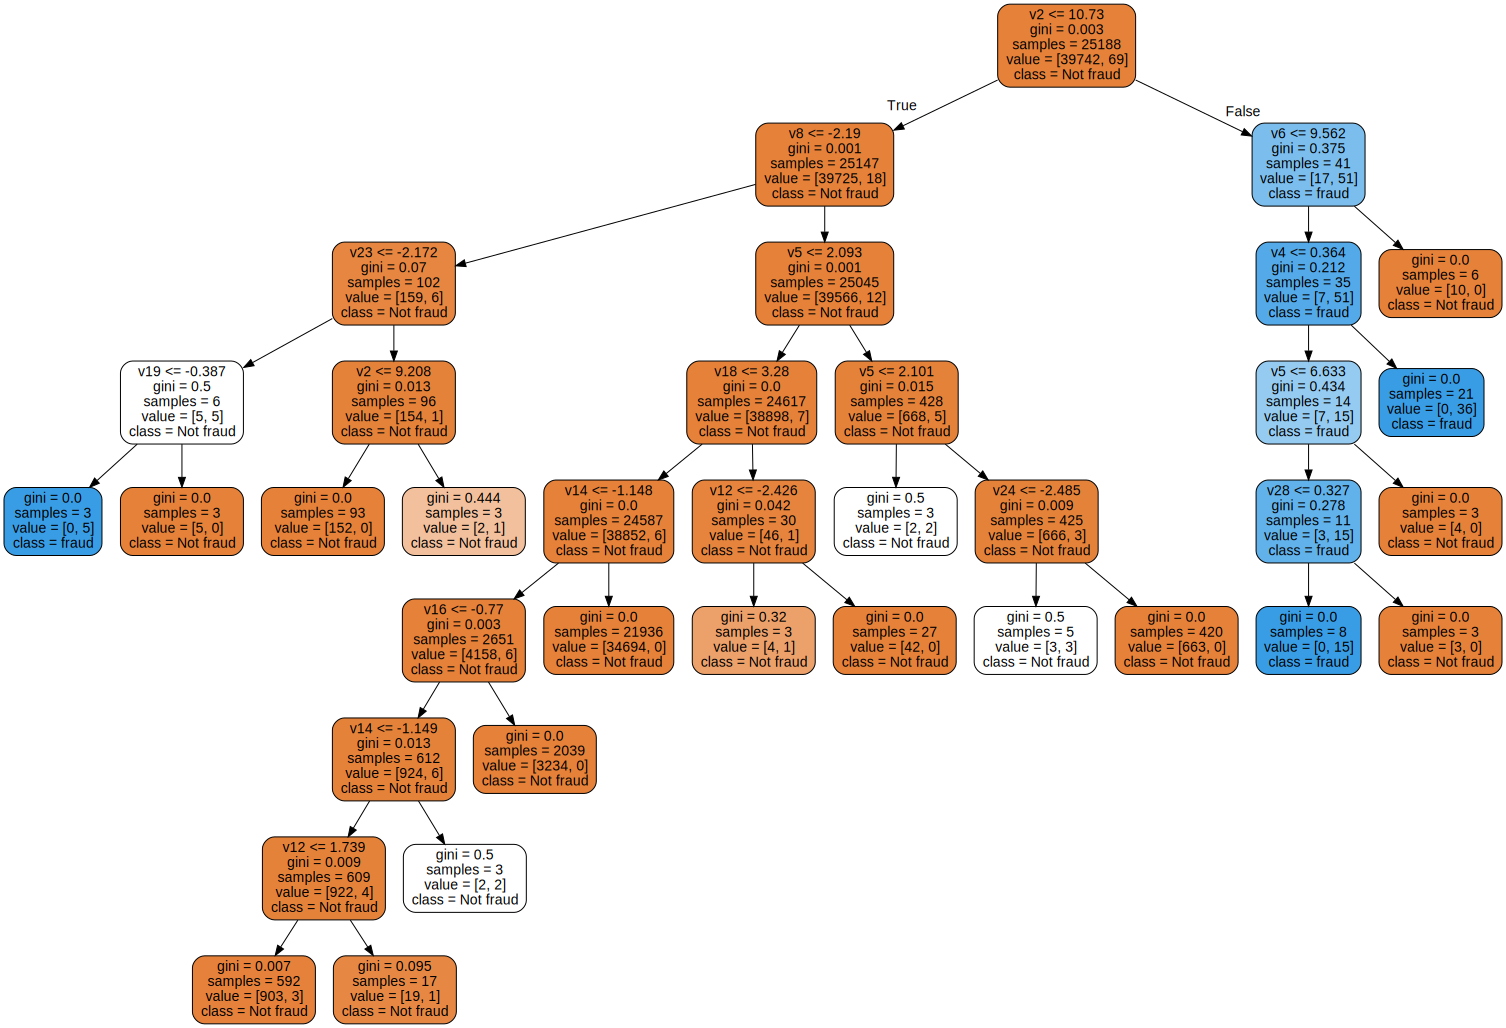

In [11]:
dt= DecisionTreeClassifier(max_depth=8,min_samples_leaf=3, max_features=12, random_state=42)
dt.fit(X_train, y_train)

rf_clf=rf_pipeline['clf']

cols=X_train.columns

fn=X_train.columns

#fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=600)

exported = export_graphviz(rf_clf.estimators_[0], 
                           feature_names=fn,
                           decision_tree=dt,
                           class_names=['Not fraud','fraud'],
                           filled=True, impurity=True, 
                           rounded=True)


#exported=tree.export_graphviz(
#    chosen_tree,
#    decision_tree=dt,
#    out_file=None,
#    feature_names=cols,
#    precision=1,
#    class_names=['Not fraud','fraud'],
#    filled=True)

graph=graphviz.Source(exported)
display(graph)

Average Precision 0.001875402918595792
Precision 0.001875402918595792 Recall 1.0
precision and recall are inversely related


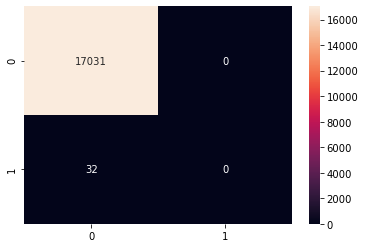

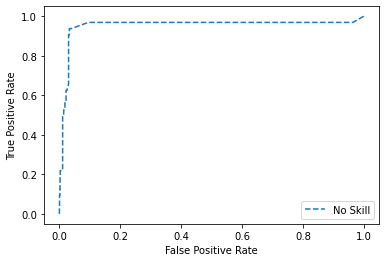

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17031
           1       0.00      0.00      0.00        32

    accuracy                           1.00     17063
   macro avg       0.50      0.50      0.50     17063
weighted avg       1.00      1.00      1.00     17063



C:\Users\dnishimoto.BOISE\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [12]:
rf_predicted=rf_pipeline['clf'].predict(X_test)
rf_predict_proba=rf_pipeline['clf'].predict_proba(X_test)
average_precision = average_precision_score(y_test, rf_predicted)
print("Average Precision",average_precision)

precision, recall, _ = precision_recall_curve(y_test,rf_predicted)
print("Precision {} Recall {}".format(precision[0],recall[0]))

print("precision and recall are inversely related")

cm = confusion_matrix(y_test,rf_predicted)
sns.heatmap(cm,annot=True,fmt='g')
plt.show()


ns_fpr, ns_tpr, _ = roc_curve(y_test, rf_predict_proba[:,1])
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

rpt=classification_report(y_test,rf_predicted)
print(rpt)

In [13]:
param_grid={
'max_depth':[1,2,3,8],
'max_features': [2,3],
'min_samples_leaf': [3,4,5],
'min_samples_split': [1,2,4],
'n_estimators': [10,20,30]
}

grid_search_model=GridSearchCV(estimator=rf_pipeline['clf'],
                              param_grid=param_grid, cv=5, n_jobs=2, scoring='f1')

grid_search_model.fit(X_train,y_train)


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_depth=8, max_features=12,
                                              min_samples_leaf=3,
                                              n_estimators=10,
                                              random_state=42),
             n_jobs=2,
             param_grid={'max_depth': [1, 2, 3, 8], 'max_features': [2, 3],
                         'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [1, 2, 4],
                         'n_estimators': [10, 20, 30]},
             scoring='f1')

In [14]:
print(grid_search_model.best_params_)

{'max_depth': 8, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 10}


In [15]:
print("XGboost classifier")

XGboost classifier


In [16]:
xg_model= xgb.XGBClassifier(objective='binary:logistic',n_estimators=10,seed=123)

xg_model.fit(X_train,y_train)


[06:55:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\dnishimoto.BOISE\AppData\Local\Continuum\anaconda3\envs\deeplearning\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=10, n_jobs=4, num_parallel_tree=1, random_state=123,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [17]:
#https://matplotlib.org/3.1.0/gallery/pie_and_polar_charts/pie_and_donut_labels.html
def func(pct, allvals):
    absolute = int(round(pct/100.*np.sum(allvals)))
    return "{:.1f}%\n({:d} )".format(pct, absolute)

def drawPieChart(label,data,title):
    fig, ax = plt.subplots(figsize=(6, 3), subplot_kw=dict(aspect="equal"))
    wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"))

    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(arrowprops=dict(arrowstyle="-"), bbox=bbox_props, zorder=0, va="center")

    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1)/2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = "angle,angleA=0,angleB={}".format(ang)
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
    
        ax.annotate(label[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)
    plt.title(title)
    plt.show()


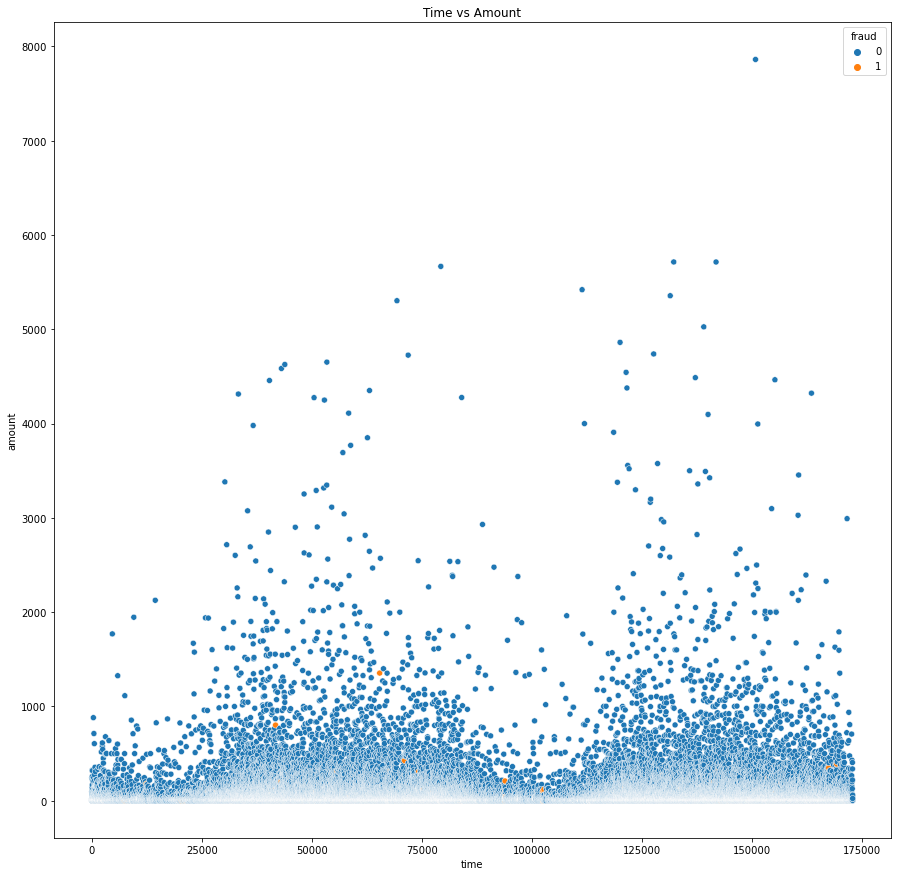

In [18]:
#print(creditcard['fraud'])
fig,ax=plt.subplots(figsize=(15,15))
sns.scatterplot(data=creditcard,x='time',y='amount',hue='fraud',ax=ax)
plt.title("Time vs Amount")
plt.show()

Predicted fraud count  25


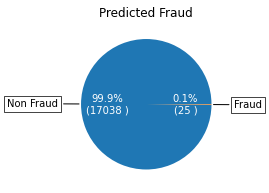

In [19]:
y_pred=xg_model.predict(X_test)

print("Predicted fraud count ",len(y_pred[y_pred==1]))
buffer=pd.Series(y_pred)
#buffer.value_counts().plot(kind='pie')
#plt.show()

drawPieChart(['Non Fraud','Fraud'],buffer.value_counts(),"Predicted Fraud")



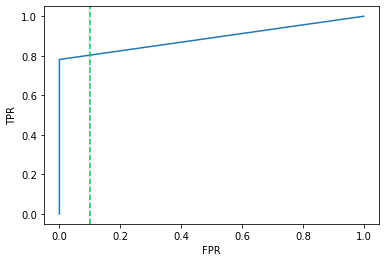

In [20]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)   # precision_recall_curve
roc = pd.DataFrame({'FPR':fpr,'TPR':tpr,'Thresholds':thresholds})

_ = plt.figure()
plt.plot(roc.FPR, roc.TPR)
plt.axvline(0.1, color = '#00C851', linestyle = '--')
plt.xlabel("FPR")
plt.ylabel("TPR")

plt.show()

In [21]:
accuracy = float(np.sum(y_pred==y_test))/y_test.shape[0]
print("accuracy: %f" % (accuracy))

accuracy: 0.999590


In [22]:
#cross validation

dmatrix=xgb.DMatrix(data=creditcard.iloc[:,:-1],
    label=creditcard.fraud)
params={"objective":"binary:logistic","max_depth":4}

cv_results=xgb.cv(dtrain=dmatrix, params=params, nfold=4,
    num_boost_round=10, metrics='error', as_pandas=True)

print("Accuracy: %f" %((1-cv_results["test-error-mean"]).iloc[-1]))

Accuracy: 0.999420


In [23]:
# cross validation area under curve
cv_results = xgb.cv(dtrain=dmatrix, params=params, 
                  nfold=3, num_boost_round=5, 
                  metrics="auc", as_pandas=True, seed=123)

# Print cv_results
print(cv_results)

# Print the AUC
print((cv_results["test-auc-mean"]).iloc[-1])

   train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0        0.941189       0.004627       0.909967      0.034740
1        0.943558       0.006600       0.915366      0.036943
2        0.945969       0.003573       0.915361      0.036955
3        0.945969       0.003578       0.915358      0.036955
4        0.948365       0.002271       0.945640      0.007842
0.9456403333333333


In [24]:


auc= roc_auc_score(y_test, y_pred)

print(auc)

0.890625


In [25]:
print("Voting Classifier")

Voting Classifier


C:\Users\dnishimoto.BOISE\AppData\Local\Continuum\anaconda3\envs\deeplearning\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[06:55:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Predicted fraud count  25


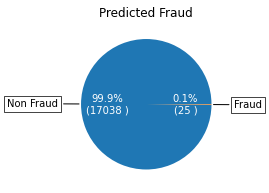

In [26]:
ensemble_model = VotingClassifier(estimators=[('lr', lr_model), ('rf', rf_pipeline['clf']), ('dt', xg_model)], voting='hard')

ensemble_model.fit(X_train, y_train)
y_predict=ensemble_model.predict(X_test)

print("Predicted fraud count ",len(y_pred[y_pred==1]))
buffer=pd.Series(y_pred)
#buffer.value_counts().plot(kind='pie')
#plt.show()

drawPieChart(['Non Fraud','Fraud'],buffer.value_counts(),"Predicted Fraud")

<Figure size 432x288 with 0 Axes>

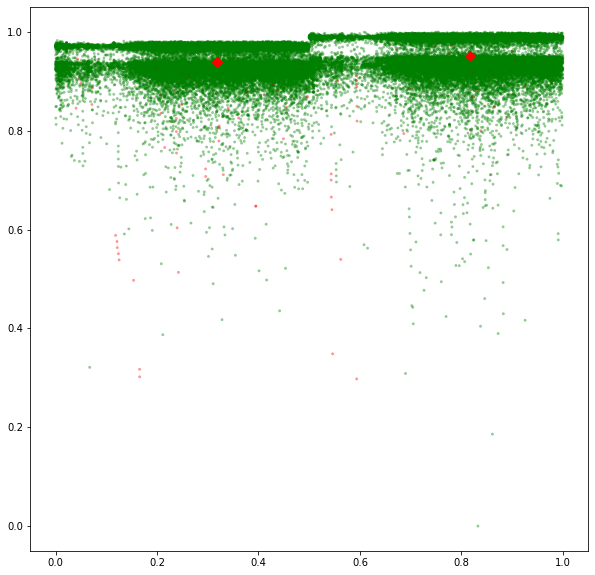

In [28]:
X_km=np.array(creditcard).astype(np.float)
scaler =MinMaxScaler()
X_scaled=scaler.fit_transform(X_km)
model=KMeans(n_clusters=2, random_state=42).fit(X_scaled)

xs = X_scaled[:,0]
ys = X_scaled[:,1]

#labels=creditcard['fraud']
colors=['red' if x==1 else 'green' for x in creditcard['fraud']]


plt.clf()
plt.figure(figsize=(10,10))
# Make a scatter plot of xs and ys, using labels to define the colors
_=plt.scatter(xs,ys,c=colors, alpha=0.3,s=4)

#ggplot(creditcard, aes(x=xs, y=ys)) + geom_point(color='darkblue')
    
# Assign the cluster centers: centroids
centroids = model.cluster_centers_
# Assign the columns of centroids: centroids_x, centroids_y
centroids_x = centroids[:,0]
centroids_y = centroids[:,1]

# Make a scatter plot of centroids_x and centroids_y
_=plt.scatter(centroids_x,centroids_y, marker='D',s=50,c='red')
plt.show()


In [133]:
X_clusters=model.predict(X_scaled)

X_cluster_centers=model.cluster_centers_

#calculate the distance to the cluster centroid for each point

dist = [np.linalg.norm(x-y) for x,y in zip(X_scaled,X_cluster_centers[X_clusters])]

km_y_pred=np.array(dist)
km_y_pred[dist>=np.percentile(dist,93)]=1
km_y_pred[dist<np.percentile(dist,93)]=0

print("predicted {} count {}".format(np.sum(km_y_pred),len(km_y_pred)))

predicted 3982.0 count 56874


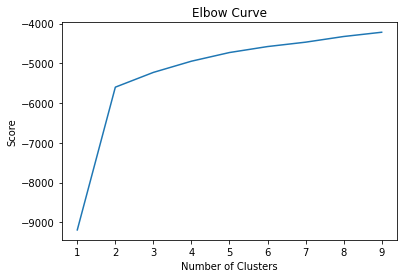

In [97]:
clust=range(1,10)
kmeans=[KMeans(n_clusters=i) for i in clust]
score=[kmeans[i].fit(X_scaled).score(X_scaled) for i in range(len(kmeans))]

plt.plot(clust,score)
plt.xlabel("Number of Clusters")
plt.ylabel("Score")
plt.title("Elbow Curve")
plt.show()